# February Grant Deadline Notebook
## <u>Notebook Goals</u>
### Provide a "fill-in-the-blanks" notebook for Nadine to perform the following for data from individual animals:
> 1. Align the signals from Tucker Davis Technologies Devices (i.e. Photometry measurements + GuPPy z-score) <br>
> with DeepLabCut data and MoSeq scoring of behavioral events <br>
> 2. Average data around 10s window of behavioral events (movement onset, movement offset, behavioral syllable onset) <br>
> 3. Plot individual traces <br>
>    Plot averaged traces <br>



#### How to use this notebook: 
- follow steps & run cells one at a time (run cells by pressing shift+enter, or Triangle button at top) 
- For some cells, you will need to enter your own subject information, path and folder path names, etc., to do so, comment out existing code (with '#' character), uncomment code blocks where you type in your own values
- Run code cells in sequence of notebook
- If an output is confusing or you face errors, try going to top bar and clicking "Kernel" -> "restart Kernel and Clear Outputs of all cells" and start over from the top of the notebook
***

### Step 1: Package Imports
note: you will need to make sure you have the following installed on your computer, either pip or conda install: <br>
      h5py, matplotlib, numpy, pandas, seaborn, tdt, scipy <br> Here's how you do that! <br>
I recommend making a virtual environment in Anaconda (for instance, one called "feb_grant_env"), this can be done by opening an Anaconda shell and typing in the following: <br>
1. create conda environment <br> ```conda create -n feb_grant_env python=3.10.13``` <br> then activate the environment <br>
2. ```conda activate feb_grant_env``` <br> then download the necessary packages <br>
3. ```conda install h5py, matplotlib, numpy, pandas, seaborn, tdt, scipy```

if you are not using Anaconda then use a Python virtual environment, you can create this in Powershell using the following:<br>
1. create python venv <br> ```python -m venv feb_grant_env```<br>
2. <br>On Windows:<br>```feb_grant_env\Scripts\activate```<br>On Mac:<br>```source feb_grant_env/bin/activate```<br>
3. <br> ```python -m pip install h5py, matplotlib, numpy, pandas, seaborn, tdt, scipy```
<br><br>

Assuming that you were able to follow the above steps then you are ready to use the notebook

In [1]:
# package imports

from collections import (
    defaultdict,  # use for creating dictionary of syllable DataFrames
)

import h5py  # Access data saved in hierarchical data format HDF5 -- for GuPPy
import matplotlib.pyplot as plt  # for plotting
import numpy as np  # NumPy for matrix operations and general maths
import pandas as pd  # Pandas for imports and data processing
import seaborn as sns  # for more complex plotting
import tdt  # Tucker-Davis Technologies Software Development Kit (SDK)
from scipy import interpolate  # for creating interpolation functions for data analysis

***
### Step 2: Define manually measured delay between the TDT system and the video data (i.e. DLC and MoSeq)

In [2]:
# example
TDT_vs_video_time_diff = 43.17

# TDT_vs_video_time_diff = _ _ _ _ _ (type in your delay between video and photometery onset)

***
## Step 3: Define paths for different datasets

- __DLC_path__ contains movement of animal determined by DeepLabCut in .csv format (1 mouse, 1 session)
- __tdt_path__ folder that contains the "block" data from the Tucker-Davis Technologies photometry recording in Struct format (1 mouse, 1 session)
- __guppy_path__ contains the deltaF/F (Z-Score) of the photometry recording as determined by GuPPy protocol in hdf5 format (1 mouse, 1 session)
- __moseq_main_path__ a very large dataset that contains MoSeq data from all animals and all trials in .csv format (all mice, all trials)

In [3]:
DLC_path = "/Users/migueldiaz/Documents/Mena Lab/MJFF_Moseq_speed_TDT/NG23002_Session1/NG23002_session1_DLC.csv"
# DLC_path = "__________" (type in the path to your .csv file for your session & animal that you are analyzing
tdt_path = "/Users/migueldiaz/Documents/Mena Lab/MJFF_Moseq_speed_TDT/NG23002_Session1"
# tdt_path = "__________" (type in the path to your FOLDER for your session & animal that you are analyzing that contains your tdt files
guppy_path = "/Users/migueldiaz/Documents/Mena Lab/MJFF_Moseq_speed_TDT/NG23002_Session1/z_score.hdf5"
# guppy_path = "__________" (type in the path to your .hdf5 file for your session & animal that you are analyzing that contains your guppy output

moseq_main_path = (
    "/Users/migueldiaz/Documents/Mena Lab/MJFF_Moseq_speed_TDT/MJFF01-02_moseq_df.csv"
)
# moseq_main_path = "________" (type in the path to your master moseq file .csv that contains all of your behavioral syllables

### Step 4: Data Imports
__now we will read in all of our data__

In [4]:
# read in large moseq file -- this tends to take a little while
main_moseq = pd.read_csv(moseq_main_path)

/var/folders/fw/n97s2lw13v7d0brxq53jt7xh0000gn/T/ipykernel_7734/618720302.py:2: DtypeWarning: Columns (24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  main_moseq = pd.read_csv(moseq_main_path)


In [5]:
# read in motion data
DLC_data = pd.read_csv(DLC_path, index_col=0, header=None)

# read in tdt data
tdt_data = tdt.read_block(tdt_path)

# read in GuPPy data
with h5py.File(guppy_path, "r") as file:
    data_key = list(file.keys())[0]
    guppy_array = np.array(file[data_key])

# Since the z-score data was already truncated in Guppy, add back 305
# datapoints (=1sec)of NaN at the beginning of all GuPPY fields for consistency
# with behavioral events. 1sec = 305 rows
nan_vector = np.full((305), np.nan)
guppy_data = pd.DataFrame(np.hstack([nan_vector, guppy_array]), columns=["zscore"])

Found Synapse note file: /Users/migueldiaz/Documents/Mena Lab/MJFF_Moseq_speed_TDT/NG23002_Session1/Notes.txt
read from t=0s to t=1871.25s


***
# Open Field Motion Data 
### Step 5: Calculate Velocity & Acceleration and Align that to TDT device timescale
Measured by DeepLabCut

notes: 
- original x, y units are in pixels
- convert pixels to meters or centimeters to calculate speed
- calculate speed (note need >1 data point to calculate, so start from second row)
- convert to the same time axis as photometry data.
- calculate acceleration (note need >1 velocity data point to calculate, so start from 3rd row)

In [6]:
# get speed from motion data, place data on same timescale as tdt device, calculate acceleration from motion data

DLC_data.columns = ["x", "y", "confidence"]

m_per_px = 0.001  # will need to make sure this value is correct 2/14/24, I am suspicious that this value is incorrect, perhaps off by order of magnitude

# Initialize the 'speed' column
DLC_data["speed"] = np.nan
# Calculate speed
speed_values = np.hypot(np.diff(DLC_data["x"].values), np.diff(DLC_data["y"].values))
# Start from the second row
DLC_data["speed"].iloc[1:] = speed_values
# Making the first row 0
DLC_data["speed"].iloc[0] = 0
# Convert to meters per pixel
DLC_data["speed"] *= m_per_px
# Convert to cm/s
DLC_data["speed"] *= 100

# place the data on the same time axis as the photometry data
DLCfps = 14.3
DLC_data["time"] = (
    DLC_data.index + 1
) / DLCfps  # note: must add 1 to get frame number because Python indexes from zero
# use the manually scored difference to get the onset of the video in line with the TDT device
DLC_data["time_TDT"] = DLC_data["time"] + TDT_vs_video_time_diff
DLC_data.sort_values(by="time_TDT", ignore_index=True, inplace=True)

# Initialize the 'acceleration' column
DLC_data["acceleration"] = np.nan
# Calculate Acceleration
acceleration_values = np.diff(DLC_data["speed"].iloc[1:]) / np.diff(
    DLC_data["time"].iloc[1:]
)
# Start from second row
DLC_data["acceleration"].iloc[2:] = acceleration_values
# Making first two rows zero
DLC_data["acceleration"].iloc[0:2] = 0

DLC_data

,x,y,confidence,speed,time,time_TDT,acceleration
0,186.935089,145.666336,0.999993,0.000000,0.069930,43.239930,0.000000
1,187.002411,145.765137,0.999991,0.011956,0.139860,43.309860,0.000000
2,187.020096,145.765137,0.999990,0.001768,0.209790,43.379790,-0.145677
3,187.130554,145.738068,0.999991,0.011373,0.279720,43.449720,0.137340
4,187.178925,145.738068,0.999991,0.004837,0.349650,43.519650,-0.093460
...,...,...,...,...,...,...,...
25827,393.113586,182.950592,0.999995,0.000000,1806.153846,1849.323846,-0.052303
25828,393.211060,182.950592,0.999995,0.009747,1806.223776,1849.393776,0.139387
25829,393.610779,182.950592,0.999996,0.039972,1806.293706,1849.463706,0.432212
25830,393.610779,182.891968,0.999997,0.005862,1806.363636,1849.533636,-0.487766


*** 
## Step 6: Set movement onset and offset criteria and get the indices/timepoints for all movement onsets and offsets
note: This still needs refinement, but these criteria should be reasonable for current grant proposal<br>
I arrived at these with some trial and error, they produced reasonable results for me

In [7]:
# note: I am not confident in these units for speed and acceleration, I think the converstion factor from frame rate to speed is incorrect
# these are arbitrary thresholds
speed_threshold = 0.1  # cm/s,
accel_threshold = 0.1  # cm/s^2

# initialize a Pandas DataFrame Column (i.e. a Series) as False
DLC_data["movement_onset"] = False
for i in range(1, len(DLC_data)):
    # criteria for movement onset
    if (
        DLC_data["acceleration"].iloc[i]
        >= accel_threshold  # Check if the speed crosses acceleration threshold at that frame
        and DLC_data["acceleration"].iloc[i - 1]
        < accel_threshold  # check that speed is below that acceleration threshold in the previous frame
        and (
            DLC_data["speed"].iloc[i : i + 28] >= speed_threshold
        ).all()  # check that for ~ the subsequent 2 seconds (28 frames) the speed is above speed threshold
        and (
            DLC_data["speed"].iloc[i - (14 * 5) : i - 14] <= 2 * speed_threshold
        ).all()  # check that for ~ the previous 5 seconds the speed is less than or equal to 2 x speed threshold
        and DLC_data["time"].iloc[i]
        > 5  # make sure this happens after the first 5 seconds of the video so that there is a complete amount of data
    ):
        DLC_data.at[i, "movement_onset"] = True

# perform the opposite operation to see when movements come to a close

DLC_data["movement_offset"] = False
for i in range(1, len(DLC_data)):
    # criteria for movement offset
    # note: these aren't quite the criteria that we decided on, but we get very few events, so this gave reasonable events
    if (
        (DLC_data["acceleration"].iloc[i] == 0)  # acceleration at current frame is zero
        and (
            DLC_data["speed"].iloc[i - 14 : i - 7] >= speed_threshold
        ).all()  # speed in 1s to 0.5s leading up to current frame is above speed threshold
        and (
            DLC_data["speed"].iloc[i + 1 : i + 7] <= speed_threshold
        ).all()  # speed for 0.5s after the current frame is below speed threshold
        # and not (DLC_data["speed"].iloc[i-(14*6):i]).isna().all()
        and DLC_data["time"].iloc[i] > 5 # make sure this happens after the first 5 seconds of the video so that there is a complete amount of data
    ):
        DLC_data.at[i, "movement_offset"] = True

__SANITY CHECK -- run following cell to check "how many movement onsets and offsets do we get?"__

In [8]:
num_onsets = DLC_data[DLC_data["movement_onset"]].shape[0]
print(f"using the current criteria, there are {num_onsets} movement onset events")
num_onsets = DLC_data[DLC_data["movement_offset"]].shape[0]
print(f"using the current criteria, there are {num_onsets} movement offset events")

using the current criteria, there are 9 movement onset events
using the current criteria, there are 5 movement offset events


__Step 7: clean the DLC DataFrame__
note: once you run this cell and these columns are dropped, then running it again will produce an error

In [9]:
DLC_data.drop(columns=["x", "y", "confidence", "time"], inplace=True)
DLC_data

,speed,time_TDT,acceleration,movement_onset,movement_offset
0,0.000000,43.239930,0.000000,False,False
1,0.011956,43.309860,0.000000,False,False
2,0.001768,43.379790,-0.145677,False,False
3,0.011373,43.449720,0.137340,False,False
4,0.004837,43.519650,-0.093460,False,False
...,...,...,...,...,...
25827,0.000000,1849.323846,-0.052303,False,False
25828,0.009747,1849.393776,0.139387,False,False
25829,0.039972,1849.463706,0.432212,False,False
25830,0.005862,1849.533636,-0.487766,False,False


***
## Photometry Data: Tucker-Davis Technologies and [GuPPy](https://github.com/LernerLab/GuPPy)
#### Step 8: extract relevant information from tdt device data
#### Step 9: place GuPPy data in same time scale as tdt

In [10]:
# extract relevant information from tdt data

tdt_duration_epoc = tdt_data.epocs.Tick.data
LED_onset_epoc = tdt_data.epocs.Tick.onset
LED_offset_epoc = tdt_data.epocs.Tick.offset
tdt_LED_df = pd.DataFrame([tdt_duration_epoc, LED_onset_epoc, LED_offset_epoc]).T
tdt_LED_df.columns = ["seconds", "onset", "offset"]
tdt_duration = tdt_data.info.duration
tdt_sampling_frequency = tdt_data.streams._465S.fs
tdt_LED_df.rename(columns={"seconds": "time_TDT"}, inplace=True)
tdt_LED_df

,time_TDT,onset,offset
0,0.0,0.000164,1.000243
1,1.0,1.000243,2.000323
2,2.0,2.000323,3.000402
3,3.0,3.000402,4.000481
4,4.0,4.000481,5.000561
...,...,...,...
1867,1867.0,1867.148329,1868.148408
1868,1868.0,1868.148408,1869.148488
1869,1869.0,1869.148488,1870.148567
1870,1870.0,1870.148567,1871.148646


In [11]:
# place GuPPy data in same time scale as tdt
guppy_data["time_TDT"] = (
    np.arange(1, len(guppy_data["zscore"]) + 1) / tdt_sampling_frequency
)
guppy_data

,zscore,time_TDT
0,NaN,0.003277
1,NaN,0.006554
2,NaN,0.009830
3,NaN,0.013107
4,NaN,0.016384
...,...,...
571034,2.765618,1871.167488
571035,2.771246,1871.170765
571036,2.776850,1871.174042
571037,2.782435,1871.177318


***
## [MoSeq](https://dattalab.github.io/moseq2-website/index.html) Data 

#### Step 10: gather data for the current animal and trial and trim to only include necessary columns.

Here we first have a very large .csv file that contains not just this individual trial, but all trials from all animals

First, we just need to gather data for the current animal and trial.

In [12]:
# get just the information for the animal and session that we are investigating

# animal_moseq = main_moseq[main_moseq["SubjectName"] == ______ ] ---- type in the subject name of your animal from Moseq file 
animal_moseq = main_moseq[main_moseq["SubjectName"] == 23002]
# session_moseq = animal_moseq[animal_moseq["SessionName"].str.contains("_______")] --- type in the name of the sessino you are interested in looking at 
session_moseq = animal_moseq[animal_moseq["SessionName"].str.contains("session1")]

In [13]:
# clean MoSeq data to only get the necessary columns 

session_moseq_subset = session_moseq.loc[
    :, ["timestamps", "labels (usage sort)", "onset"]
]
session_moseq_subset.loc[:, "seconds"] = (
    session_moseq_subset.loc[:, "timestamps"]
    - session_moseq_subset.loc[:, "timestamps"][0]
) / 1000
session_moseq_subset.loc[:, "time_TDT"] = (
    session_moseq_subset.loc[:, "seconds"]
    + TDT_vs_video_time_diff  # switched from - to + on 2/14/24
)
session_moseq_subset.drop(columns=["timestamps", "seconds"], inplace=True)

***
## Step 11: Merge all datasets on the common "time_TDT" column 
#### and clean up the merged DataFrame
#### Perform an "Outer" merge that keeps all data points whether they are in common or not

In [14]:
merged_data = guppy_data.merge(session_moseq_subset, on="time_TDT", how="outer")
merged_data = merged_data.merge(DLC_data, on="time_TDT", how="outer")
merged_data.sort_values(by="time_TDT", ignore_index=True, inplace=True)
merged_data["movement_onset"] = merged_data["movement_onset"].fillna(False)
merged_data["movement_offset"] = merged_data["movement_offset"].fillna(False)
merged_data

,zscore,time_TDT,labels (usage sort),onset,speed,acceleration,movement_onset,movement_offset
0,NaN,0.003277,NaN,NaN,NaN,NaN,False,False
1,NaN,0.006554,NaN,NaN,NaN,NaN,False,False
2,NaN,0.009830,NaN,NaN,NaN,NaN,False,False
3,NaN,0.013107,NaN,NaN,NaN,NaN,False,False
4,NaN,0.016384,NaN,NaN,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...
649766,2.765618,1871.167488,NaN,NaN,NaN,NaN,False,False
649767,2.771246,1871.170765,NaN,NaN,NaN,NaN,False,False
649768,2.776850,1871.174042,NaN,NaN,NaN,NaN,False,False
649769,2.782435,1871.177318,NaN,NaN,NaN,NaN,False,False


In [15]:
# clean up the data a bit
merged_data.rename(
    columns={
        "zscore": "zscore",
        "time_TDT": "time",
        "labels (usage sort)": "syllable",
        "onset": "onset",
        "speed": "speed",
        "acceleration": "acceleration",
        "movement_onset": "mvmtON",
        "movement_offset": "mvmtOFF",
    },
    inplace=True,
)
merged_data = merged_data.reindex(
    columns=[
        "time",
        "zscore",
        "speed",
        "acceleration",
        "mvmtON",
        "mvmtOFF",
        "syllable",
        "onset",
    ]
)
merged_data

,time,zscore,speed,acceleration,mvmtON,mvmtOFF,syllable,onset
0,0.003277,NaN,NaN,NaN,False,False,NaN,NaN
1,0.006554,NaN,NaN,NaN,False,False,NaN,NaN
2,0.009830,NaN,NaN,NaN,False,False,NaN,NaN
3,0.013107,NaN,NaN,NaN,False,False,NaN,NaN
4,0.016384,NaN,NaN,NaN,False,False,NaN,NaN
...,...,...,...,...,...,...,...,...
649766,1871.167488,2.765618,NaN,NaN,False,False,NaN,NaN
649767,1871.170765,2.771246,NaN,NaN,False,False,NaN,NaN
649768,1871.174042,2.776850,NaN,NaN,False,False,NaN,NaN
649769,1871.177318,2.782435,NaN,NaN,False,False,NaN,NaN


In [16]:
# convert all data types to appropriate types

merged_data = merged_data.astype(
    {
        "mvmtON": "boolean",
        "mvmtOFF": "boolean",
        "syllable": "category",
        "onset": "boolean",
    }
)
merged_data.dtypes

time             float64
zscore           float64
speed            float64
acceleration     float64
mvmtON           boolean
mvmtOFF          boolean
syllable        category
onset            boolean
dtype: object

***
## Step 12: Generate Interpolation Functions for Z-Score and Velocity

note: interp1d function that I use will become deprecated in future versions of SciPy<br> 
I am currently using version 1.11.4

In [17]:
speed_not_null = merged_data[~merged_data["speed"].isnull()]
zscore_not_null = merged_data[~merged_data["zscore"].isnull()]
speed_not_null

,time,zscore,speed,acceleration,mvmtON,mvmtOFF,syllable,onset
13198,43.239930,NaN,0.000000,0.000000,False,False,NaN,<NA>
13223,43.309860,NaN,0.011956,0.000000,False,False,NaN,<NA>
13247,43.379790,NaN,0.001768,-0.145677,False,False,NaN,<NA>
13271,43.449720,NaN,0.011373,0.137340,False,False,NaN,<NA>
13296,43.519650,NaN,0.004837,-0.093460,False,False,NaN,<NA>
...,...,...,...,...,...,...,...,...
643095,1849.323846,NaN,0.000000,-0.052303,False,False,NaN,<NA>
643118,1849.393776,NaN,0.009747,0.139387,False,False,NaN,<NA>
643140,1849.463706,NaN,0.039972,0.432212,False,False,NaN,<NA>
643162,1849.533636,NaN,0.005862,-0.487766,False,False,NaN,<NA>


In [18]:
# get interpolation functions for zscore and velocity

zscore_time = zscore_not_null["time"]
speed_time = speed_not_null["time"]
zscore = zscore_not_null["zscore"]
speed = speed_not_null["speed"]

# simple linear interpolation -- can try different methods in the future
z_score_interp_fxn = interpolate.interp1d(zscore_time, zscore, bounds_error=False)
speed_interp_fxn = interpolate.interp1d(speed_time, speed, bounds_error=False)

### Step 13: generate the time over which you want to sample points and the frequency you want to sample

#### this tells us a time range and frequency that we want to sample from interpolated points
#### that is, in this example, I say that I want every millisecond between 0s and 1870s

#### then I place that into a Pandas Series object for compatability with existing data

In [21]:
# generate a "time vector"/"time series", these are our sampling points, we will sample every millisecond 

time_vector = np.arange(0, 1800.001, 0.001)
time_series = pd.Series(time_vector)

In [22]:
# now, I use that time series that I used to generate points from our interpolation functions

zscore_interp = z_score_interp_fxn(time_series)
speed_interp = speed_interp_fxn(time_series)

#### Sanity Check: plot our interpolated (i.e. resampled) data over the time frame of interest

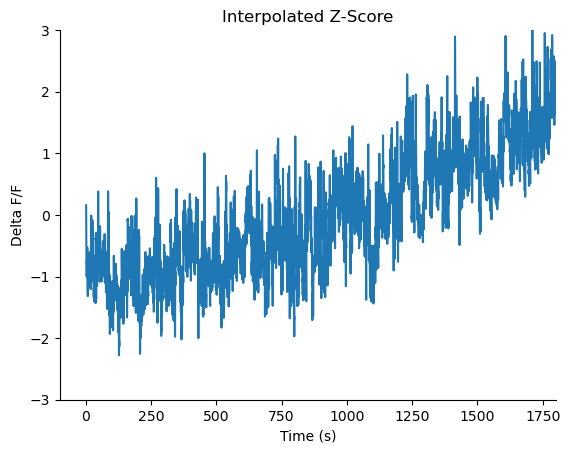

In [23]:
# plot interpolated points for sanity check
fig, ax = plt.subplots()
plt.plot(time_series, zscore_interp)
plt.title("Interpolated Z-Score")
plt.xlabel("Time (s)")
plt.xlim((-100, 1800))
plt.ylabel("Delta F/F")
plt.ylim((-3, 3))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# plt.savefig('figure.png') to export figure ... change name of figure to preferred name

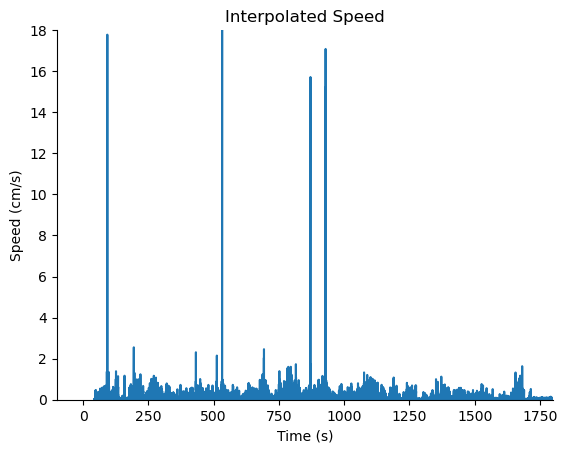

In [24]:
fig, ax = plt.subplots()
plt.plot(time_series, speed_interp)
plt.title("Interpolated Speed")
plt.xlabel("Time (s)")
plt.xlim((-100, 1800))
plt.ylabel(
    "Speed (cm/s)"
)  # note: I do not feel comfortable about these units, you could alternatively say "Speed (a.u.)"
plt.ylim((0, 18))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# plt.savefig('figure.png') to export figure ... change name of figure to preferred name

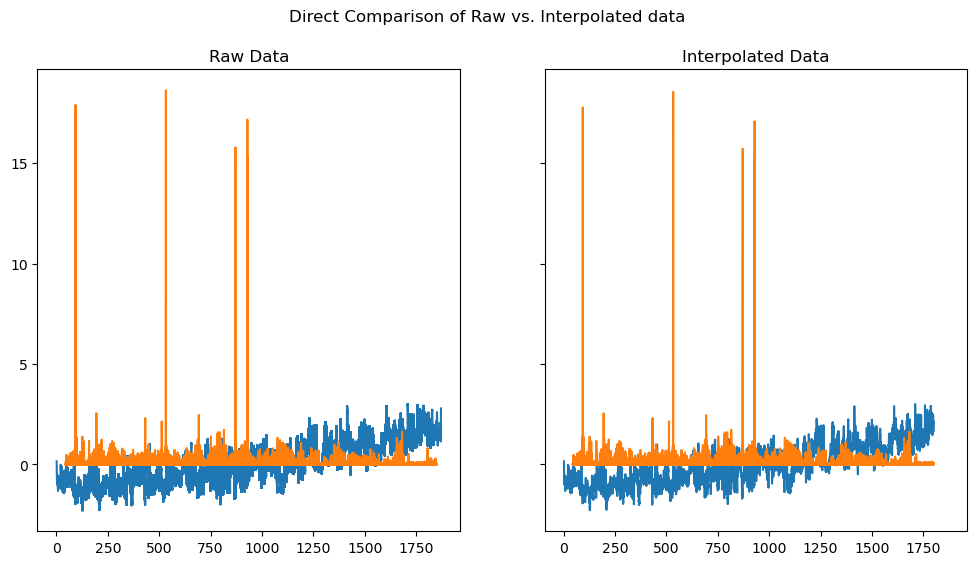

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))

fig.suptitle("Direct Comparison of Raw vs. Interpolated data")

ax1.plot(merged_data["time"], merged_data["zscore"])
speedmask = np.isfinite(merged_data["speed"])
ax1.plot(merged_data["time"][speedmask], merged_data["speed"][speedmask])
ax1.set_title("Raw Data")

ax2.plot(time_series, zscore_interp)
ax2.plot(time_series, speed_interp)
ax2.set_title("Interpolated Data")

plt.show()

# plt.savefig('figure.png') to export figure ... change name of figure to preferred name

#### Step 14: place interpolated data into a DataFrame to have it in same format as raw data

In [26]:
# interpolated data looks good, let's get it in a DataFrame to work with it like we do our raw data

interp_df = pd.DataFrame(
    {"time": time_series, "zscore": zscore_interp, "speed": speed_interp}
)
interp_df = interp_df.sort_values(by="time")
interp_df

,time,zscore,speed
0,0.000,NaN,NaN
1,0.001,NaN,NaN
2,0.002,NaN,NaN
3,0.003,NaN,NaN
4,0.004,NaN,NaN
...,...,...,...
1799996,1799.996,2.139213,0.046029
1799997,1799.997,2.139110,0.046731
1799998,1799.998,2.139007,0.047433
1799999,1799.999,2.138910,0.048135


***
# Movement Onset Analysis

# Step 15: Analyze Movement Onset Events & Generate Graphs

In [27]:
# preparatory steps

# must be 5 seconds after the start of the session and 5 seconds before the end of the session
relevant_merged_data = merged_data[
    (merged_data["time"] >= 5)
    & ((interp_df["time"].iloc[-1] - merged_data["time"]) >= 5)
]
mvmtON_df = relevant_merged_data[relevant_merged_data["mvmtON"]]
mvmtONidx = mvmtON_df.index
num_mvmt_events = mvmtON_df.index.size

speed_array = np.zeros((10000, num_mvmt_events))
zscores_array = np.zeros((10000, num_mvmt_events))
speed_array = np.zeros((10000, num_mvmt_events))
onset_event_zscores = pd.DataFrame(zscores_array)
onset_event_speed = pd.DataFrame(speed_array)

In [28]:
# get zscores and velocities into DataFrames
counter = 0
for mvmt_event in mvmtONidx:
    onset_time = merged_data.loc[mvmt_event, "time"].round(3)
    lower_bound = round(onset_time - 5.0, 3)
    upper_bound = round(onset_time + 5.0, 3)
    subset_df = interp_df.loc[
        (interp_df["time"] >= lower_bound) & (interp_df["time"] < upper_bound)
    ]
    onset_event_zscores.iloc[:, counter] = subset_df.loc[:, "zscore"]
    onset_event_speed.iloc[:, counter] = subset_df.loc[:, "speed"]

    counter += 1

In [29]:
# note: this is a variable that will have all of the z-scores for the current animal/session
onset_event_zscores

,0,1,2,3,4,5,6,7
0,-0.083437,-0.331498,0.025877,0.561765,0.492525,0.343851,0.027684,-0.066993
1,-0.084027,-0.333321,0.025536,0.561881,0.491732,0.342652,0.026243,-0.066437
2,-0.084620,-0.335158,0.025196,0.561995,0.490931,0.341453,0.024801,-0.065882
3,-0.085220,-0.337004,0.024855,0.562088,0.490116,0.340245,0.023379,-0.065326
4,-0.085820,-0.338850,0.024526,0.562182,0.489302,0.339027,0.021963,-0.064749
...,...,...,...,...,...,...,...,...
9995,-0.984937,-0.787438,0.067142,-0.301019,-0.324027,-0.280125,-0.276378,-0.347374
9996,-0.983845,-0.787017,0.066838,-0.301398,-0.324029,-0.279686,-0.276427,-0.347308
9997,-0.982735,-0.786606,0.066534,-0.301774,-0.324035,-0.279250,-0.276492,-0.347243
9998,-0.981626,-0.786195,0.066257,-0.302148,-0.324042,-0.278829,-0.276571,-0.347187


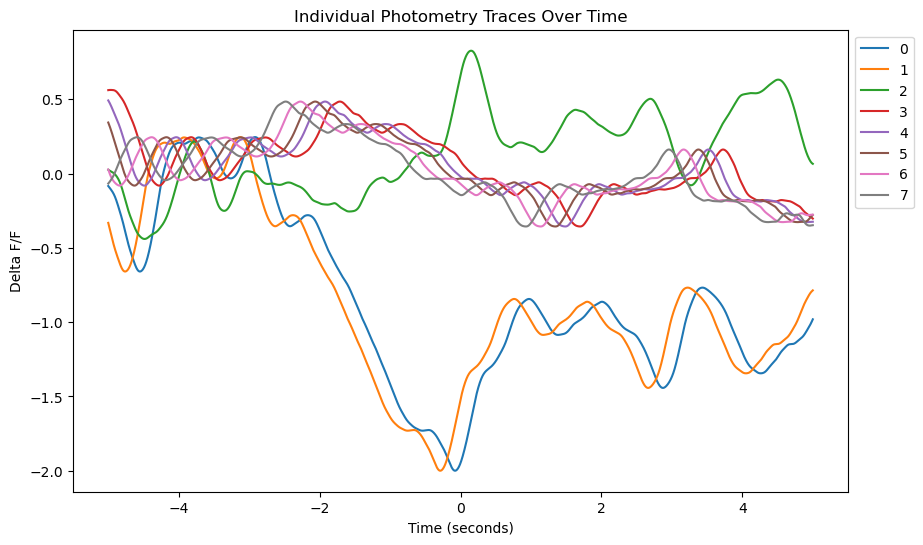

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
time_range = np.linspace(-5, 5, len(onset_event_zscores))
onset_event_zscores.index = time_range
onset_event_zscores.plot(ax=ax)
plt.title("Individual Photometry Traces Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Delta F/F")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

In [32]:
# note: this is a variable that will have all of the speed data for the current animal/session

onset_event_speed

,0,1,2,3,4,5,6,7
0,0.008170,0.017110,0.018542,0.180942,0.018702,0.049648,0.011008,0.003043
1,0.008405,0.016621,0.018471,0.182757,0.018317,0.051057,0.010804,0.002957
2,0.008639,0.016131,0.018399,0.184573,0.017931,0.052465,0.010600,0.002871
3,0.008874,0.015641,0.018327,0.186388,0.017546,0.053874,0.010396,0.002785
4,0.009109,0.015151,0.018256,0.188203,0.017160,0.055283,0.010193,0.002698
...,...,...,...,...,...,...,...,...
9995,0.160445,0.005972,0.018719,0.003004,0.010078,0.008336,0.039722,0.002966
9996,0.158972,0.006028,0.018717,0.003092,0.010266,0.008270,0.040415,0.002927
9997,0.157500,0.006084,0.018715,0.003180,0.010453,0.008205,0.041109,0.002889
9998,0.156028,0.006140,0.018713,0.003268,0.010641,0.008140,0.041803,0.002850


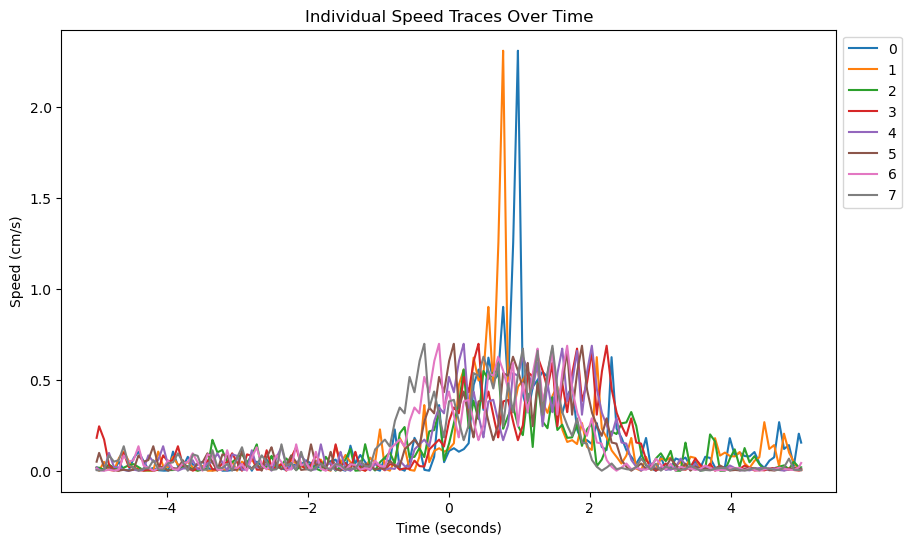

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
time_range = np.linspace(-5, 5, len(onset_event_speed))
onset_event_speed.index = time_range
onset_event_speed.plot(ax=ax)
plt.title("Individual Speed Traces Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Speed (cm/s)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

In [34]:
onset_average_speed = onset_event_speed.mean(axis=1)
onset_average_zscore = onset_event_zscores.mean(axis=1)

time = np.arange(10000)
time_seconds = ((time / 9999) * 10) - 5

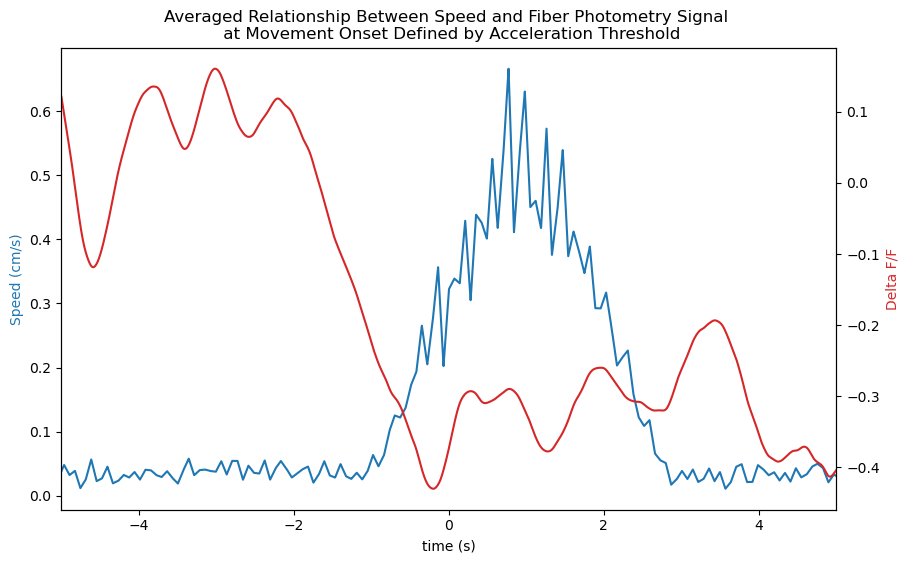

In [35]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))
time = (-300, 300)

# Plot the first set of data with the left y-axis
ax1.plot(time_seconds, onset_average_speed, color="tab:blue")
ax1.set_ylabel("Speed (cm/s)", color="tab:blue")

# Create a twin Axes sharing the xaxis
ax2 = ax1.twinx()

# Plot the second set of data with the right y-axis
ax2.plot(time_seconds, onset_average_zscore, color="tab:red")
ax2.set_ylabel("Delta F/F", color="tab:red")

ax1.set_xlabel("time (s)")
plt.xlim((-5, 5))
plt.title(
    "Averaged Relationship Between Speed and Fiber Photometry Signal \n at Movement Onset Defined by Acceleration Threshold"
)
# Show the plot
plt.show()

# plt.savefig('figure.png') to export figure ... change name of figure to preferred name

***
# Movement Offset
# Step 16: Analyze Movement Offset Events & Generate Graphs

note: some variables from onset and offset graph-making and analysis have the same names, so you must run ONSET or OFFSET data, don't try to jump back and forth or you might produce confusing results. I will clean this up in the future.

In [38]:
# preparatory steps

# must be 5 seconds after the start of the session and 5 seconds before the end of the session
relevant_merged_data = merged_data[
    (merged_data["time"] >= 5)
    & ((interp_df["time"].iloc[-1] - merged_data["time"]) >= 5)
]
mvmtOFF_df = relevant_merged_data[relevant_merged_data["mvmtOFF"]]
mvmtOFFidx = mvmtOFF_df.index
num_mvmt_events = mvmtOFF_df.index.size

speed_array = np.zeros((10000, num_mvmt_events))
zscores_array = np.zeros((10000, num_mvmt_events))
speed_array = np.zeros((10000, num_mvmt_events))
offset_event_zscores = pd.DataFrame(zscores_array)
offset_event_speed = pd.DataFrame(speed_array)

In [39]:
# get zscores and velocities into DataFrames
counter = 0
for mvmt_event in mvmtOFFidx:
    offset_time = merged_data.loc[mvmt_event, "time"].round(3)
    lower_bound = round(offset_time - 5.0, 3)
    upper_bound = round(offset_time + 5.0, 3)
    subset_df = interp_df.loc[
        (interp_df["time"] >= lower_bound) & (interp_df["time"] < upper_bound)
    ]
    offset_event_zscores.iloc[:, counter] = subset_df.loc[:, "zscore"]
    offset_event_speed.iloc[:, counter] = subset_df.loc[:, "speed"]

    counter += 1

In [40]:
offset_event_zscores

,0,1,2,3,4
0,-0.215208,-0.361511,-1.049125,1.001751,0.045880
1,-0.214382,-0.362262,-1.049070,1.002873,0.045466
2,-0.213571,-0.363014,-1.049016,1.003995,0.045069
3,-0.212759,-0.363766,-1.048960,1.005117,0.044671
4,-0.211951,-0.364497,-1.048901,1.006239,0.044274
...,...,...,...,...,...
9995,-1.276320,-0.349887,-1.421211,1.198256,1.088315
9996,-1.276275,-0.348432,-1.421654,1.198225,1.089728
9997,-1.276230,-0.346976,-1.422091,1.198195,1.091143
9998,-1.276184,-0.345540,-1.422515,1.198153,1.092558


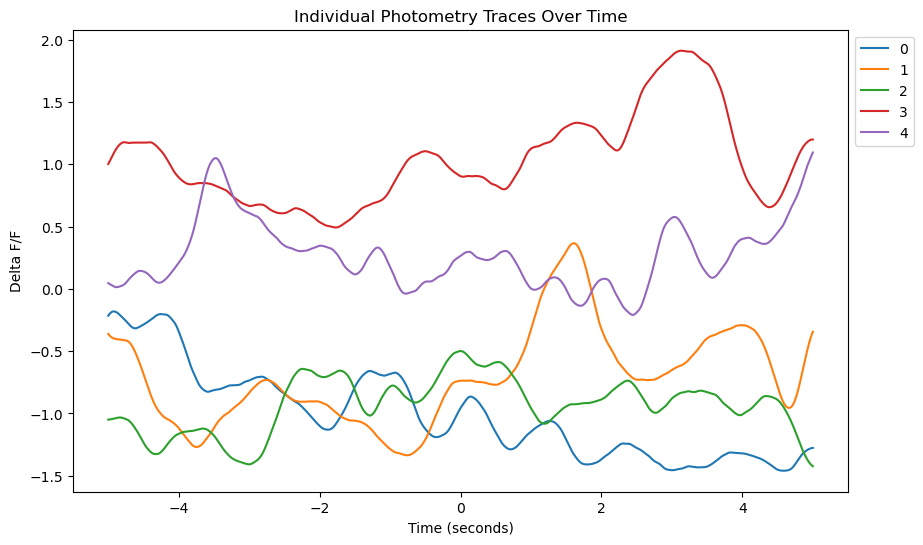

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
time_range = np.linspace(-5, 5, len(offset_event_zscores))
offset_event_zscores.index = time_range
offset_event_zscores.plot(ax=ax)
plt.title("Individual Photometry Traces Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Delta F/F")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

In [42]:
# note: this is a variable that will have all of the speed data for the current animal/session

offset_event_speed

,0,1,2,3,4
0,0.109375,0.369979,0.166163,0.006472,0.190338
1,0.111657,0.366519,0.164905,0.006551,0.186852
2,0.113940,0.363059,0.163647,0.006629,0.183366
3,0.116223,0.359599,0.162388,0.006708,0.179880
4,0.118506,0.356139,0.161130,0.006787,0.176394
...,...,...,...,...,...
9995,0.000000,0.093685,0.390276,0.041195,0.334670
9996,0.000000,0.092952,0.385979,0.040427,0.335861
9997,0.000000,0.092219,0.381681,0.039658,0.337052
9998,0.000000,0.091486,0.377383,0.038889,0.338243


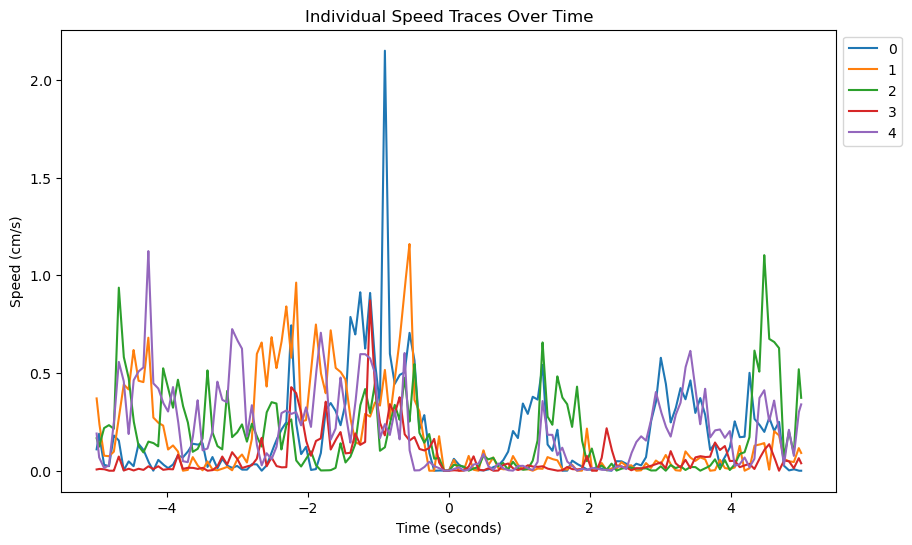

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))
time_range = np.linspace(-5, 5, len(offset_event_zscores))
offset_event_speed.index = time_range
offset_event_speed.plot(ax=ax)
plt.title("Individual Speed Traces Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Speed (cm/s)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

In [45]:
offset_average_speed = offset_event_speed.mean(axis=1)
offset_average_zscore = offset_event_zscores.mean(axis=1)

time = np.arange(10000)
time_seconds = ((time / 9999) * 10) - 5

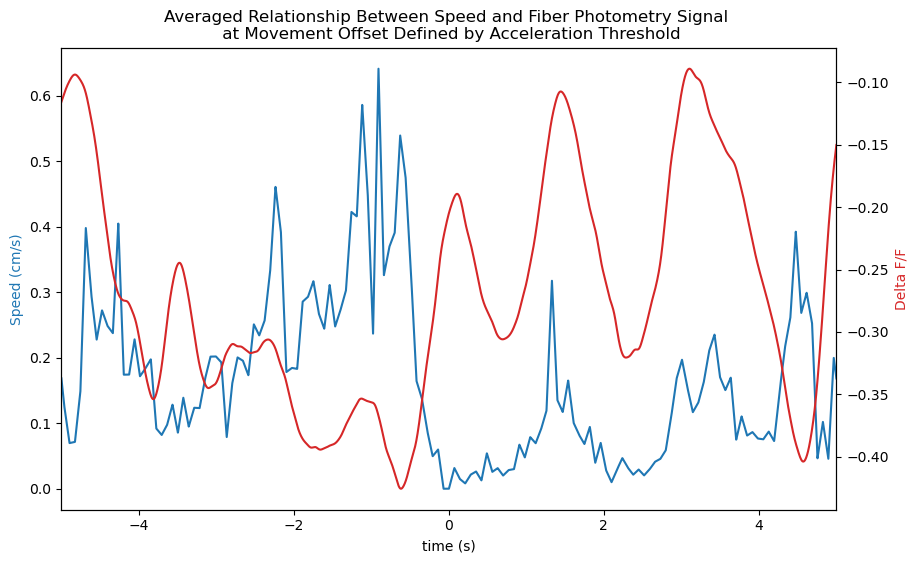

In [46]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))
time = (-300, 300)

# Plot the first set of data with the left y-axis
ax1.plot(time_seconds, offset_average_speed, color="tab:blue")
ax1.set_ylabel("Speed (cm/s)", color="tab:blue")

# Create a twin Axes sharing the xaxis
ax2 = ax1.twinx()

# Plot the second set of data with the right y-axis
ax2.plot(time_seconds, offset_average_zscore, color="tab:red")
ax2.set_ylabel("Delta F/F", color="tab:red")

ax1.set_xlabel("time (s)")
plt.xlim((-5, 5))
plt.title(
    "Averaged Relationship Between Speed and Fiber Photometry Signal \n at Movement Offset Defined by Acceleration Threshold"
)
# Show the plot
plt.show()

# plt.savefig('figure.png') to export figure ... change name of figure to preferred name

***
# Behavioral Syllable Onset
# Step 17: Analyze Behavioral Syllable Onset Events & Generate Graphs

In [47]:
# make a dictionary containing all of the data for each behavioral syllable

all_syllables = set(merged_data["syllable"].dropna().values)
syllable_events_dict = defaultdict(pd.DataFrame)

for syllable in all_syllables:
    onset_points = merged_data[merged_data["onset"]]
    syllable_onsets = onset_points[
        (onset_points["syllable"] == syllable) & (onset_points["time"].between(6, 1794))
    ]
    onset_indices = syllable_onsets.index
    num_syllable_onsets = len(onset_indices)
    syllable_array = pd.DataFrame(np.zeros((10000, num_syllable_onsets)))
    counter = 0
    for idx in onset_indices:
        syllable_onset_time = merged_data.loc[idx, "time"].round(3)
        lower_bound = round(syllable_onset_time - 5.0, 3)
        upper_bound = round(syllable_onset_time + 5.0, 3)
        subset_df = interp_df.loc[
            (interp_df["time"] >= lower_bound) & (interp_df["time"] < upper_bound)
        ]
        syllable_array.iloc[:, counter] = subset_df.loc[:, "zscore"]
        counter += 1
    syllable_events_dict[syllable] = syllable_array

### FROM THIS POINT ON, YOU ARE GOING TO WORK WITH ONE BEHAVIORAL SYLLABLE AT A TIME 
__type in the syllable you are interested in below to get the data for 5 seconds before and after onset of that particular behavioral syllable__

In [48]:
# DEFINE THE SYLLABLE YOU ARE INTERESTED IN IN THIS CELL:
syllable_of_interest = 1 # < - here type a number of any behavioral syllable you are interested in, I chose number 1

__If you want to look at a different syllable, start from the cell above and run each cell over again__

In [50]:
# type in the syllable you are interested in below to get the time period dataframe of interest
syllable_df = syllable_events_dict[syllable_of_interest]
syllable_df

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,-1.260745,-1.151292,-0.403110,-1.298772,-0.445390,-1.171310,-1.608616,-1.358614,-0.287982,-0.585833,...,0.235972,0.875063,0.822068,-0.292865,0.141634,0.975296,1.346703,0.596728,1.469991,1.281282
1,-1.261155,-1.151357,-0.402780,-1.298493,-0.445160,-1.171765,-1.609306,-1.357188,-0.288177,-0.586663,...,0.236167,0.875426,0.821119,-0.293434,0.142331,0.975238,1.346525,0.597517,1.470526,1.283938
2,-1.261565,-1.151423,-0.402464,-1.298211,-0.444929,-1.172221,-1.609996,-1.355761,-0.288356,-0.587488,...,0.236366,0.875781,0.820170,-0.294002,0.143031,0.975183,1.346344,0.598308,1.471054,1.286593
3,-1.261944,-1.151488,-0.402166,-1.297930,-0.444698,-1.172647,-1.610646,-1.354334,-0.288532,-0.588312,...,0.236565,0.876135,0.819209,-0.294572,0.143736,0.975128,1.346161,0.599099,1.471582,1.289241
4,-1.262312,-1.151550,-0.401869,-1.297646,-0.444466,-1.173071,-1.611294,-1.352907,-0.288708,-0.589130,...,0.236764,0.876488,0.818249,-0.295144,0.144440,0.975075,1.345977,0.599903,1.472110,1.291873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-1.662941,-0.303983,-0.762457,-1.333064,-1.152154,-1.053109,-1.880798,-1.726641,-1.203039,-1.379277,...,0.385766,0.545394,0.883057,0.296341,0.463737,1.324092,1.542489,2.463483,0.906699,1.408256
9996,-1.662830,-0.302993,-0.762504,-1.332784,-1.152411,-1.053936,-1.880734,-1.726238,-1.203610,-1.379483,...,0.384592,0.544855,0.883044,0.295263,0.463792,1.324198,1.542604,2.463052,0.906975,1.407815
9997,-1.662719,-0.302003,-0.762558,-1.332504,-1.152667,-1.054769,-1.880674,-1.725827,-1.204174,-1.379689,...,0.383418,0.544316,0.883000,0.294185,0.463862,1.324303,1.542711,2.462621,0.907256,1.407374
9998,-1.662608,-0.301017,-0.762612,-1.332225,-1.152924,-1.055605,-1.880617,-1.725416,-1.204738,-1.379894,...,0.382244,0.543777,0.882947,0.293113,0.463931,1.324409,1.542817,2.462192,0.907536,1.406924


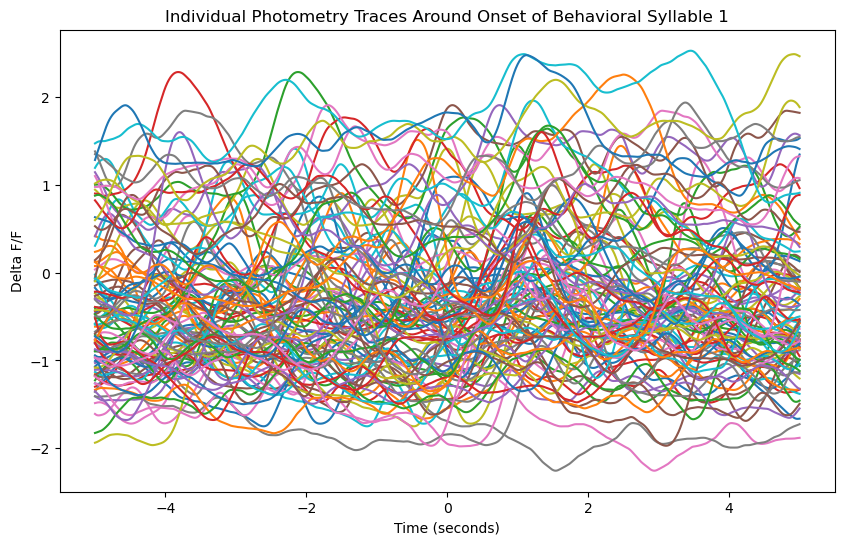

In [53]:
fig, ax = plt.subplots(figsize=(10, 6))
time_range = np.linspace(-5, 5, len(syllable_df))
syllable_df.index = time_range
syllable_df.plot(ax=ax)
plt.title(f"Individual Photometry Traces Around Onset of Behavioral Syllable {syllable_of_interest}")
plt.xlabel("Time (seconds)")
plt.ylabel("Delta F/F")
ax.get_legend().remove()
plt.show()

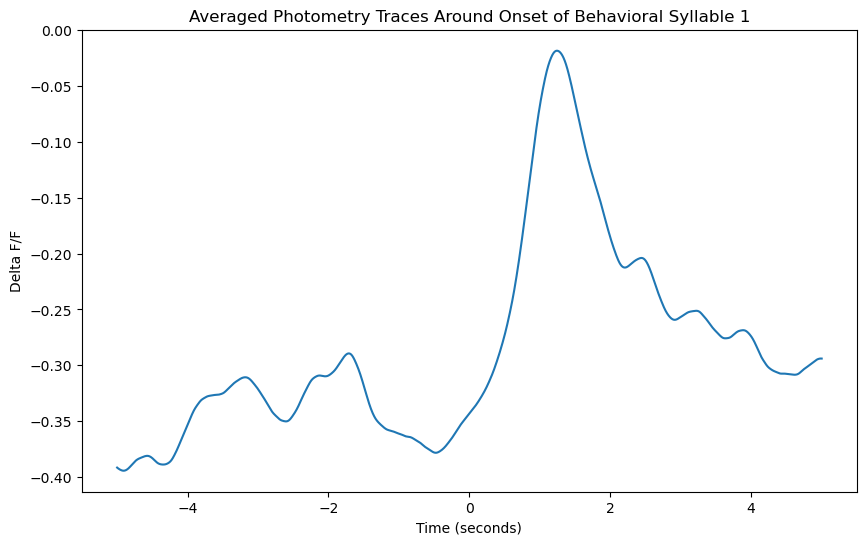

In [54]:
average_syllable = syllable_df.mean(axis=1)
fig, ax = plt.subplots(figsize=(10, 6))
time_range = np.linspace(-5, 5, len(syllable_df))
average_syllable.index = time_range
average_syllable.plot(ax=ax)
plt.title(f"Averaged Photometry Traces Around Onset of Behavioral Syllable {syllable_of_interest}")
plt.xlabel("Time (seconds)")
plt.ylabel("Delta F/F")
plt.show()

# Well, that's all I have for now, hope this is at least a bit helpful!! - Miguel